In [53]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
from tqdm import tqdm
from matplotlib.animation import FuncAnimation


In [54]:
def Greens_free_field(x, y, x0, y0, f, c):
    """Compute the 2D Green's function in free field."""
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    k = 2 * np.pi * f / c
    G = np.exp(-1j * k * r) / (4 * np.pi * r)
    return G

class FCN(nn.Module):
    """Fully Connected Network."""
    def __init__(self, n_in, n_out, n_units, n_layers):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(n_in, n_units),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                        nn.Linear(n_units, n_units),
                        activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_units, n_out)
    def forward(self, r):
        r = self.fcs(r)
        r = self.fch(r)
        r = self.fce(r)
        return r

In [55]:
# Define parameters
c = 343.0
f = 1000.0
k = 2 * np.pi * f / c
L = 1.0
T = 2e-3

r = np.linspace(0.1, L, 100)
t = np.linspace(0, T, 100)
r_grid, t_grid = np.meshgrid(r, t)
rt = np.array([r_grid.flatten(), t_grid.flatten()]).T

p_ref = np.exp(1j * (2 * np.pi * f * rt[:, 1] - k * rt[:, 0])) / (4 * np.pi * rt[:, 0])
p_ref = p_ref.real.reshape(r_grid.shape)

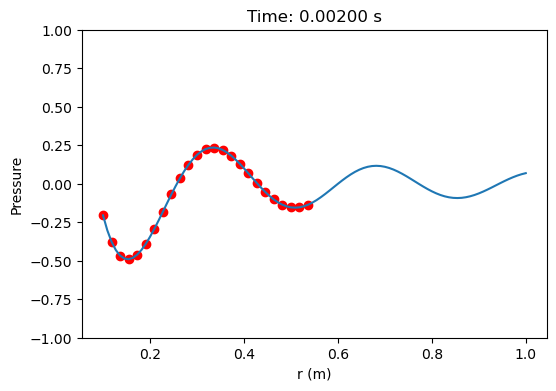

In [56]:
p_obs = p_ref[:, 0:50:2]
r_obs = r[0:50:2]
rt_obs = np.array([r_grid[:, 0:50:2].flatten(), t_grid[:, 0:50:2].flatten()]).T

fig = plt.figure(figsize=(6, 4))
line, = plt.plot(r, p_ref[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line.set_ydata(p_ref[frame, :])
    for coll in plt.gca().collections:
        coll.remove()
    plt.scatter(r_obs, p_obs[frame, :], color='red', label='Observations')
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line,

ani = FuncAnimation(fig, update, frames=p_ref.shape[0], interval=100, blit=True)
ani.save('wave_animation.gif', writer='pillow', fps=10)

In [57]:
n_in = 2
n_out = 1
n_hidden = 32
n_layers = 3
n_epochs = int(2e4)

rt_obs = torch.tensor(rt_obs, dtype=torch.float32).requires_grad_(True)
p_obs = torch.tensor(p_obs.reshape(-1,1), dtype=torch.float32).requires_grad_(True)
rt = torch.tensor(rt, dtype=torch.float32).requires_grad_(True)

model = FCN(n_in, n_out, n_hidden, n_layers)

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    p = model(rt_obs)
    loss = mse_loss(p, p_obs)

    # backpropagate
    loss.backward()
    optimizer.step()
    if i == 0:
        loss_history = []
    loss_history.append(loss.item())


  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [01:57<00:00, 169.60it/s]


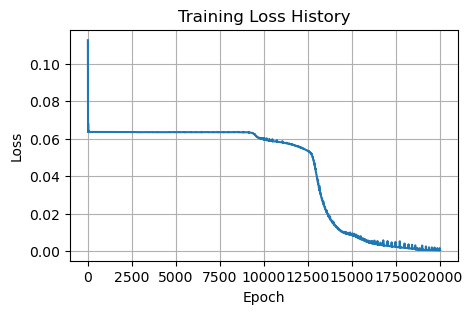

In [58]:
plt.figure(figsize=(5, 3))
plt.plot(np.array(loss_history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid()
plt.show()

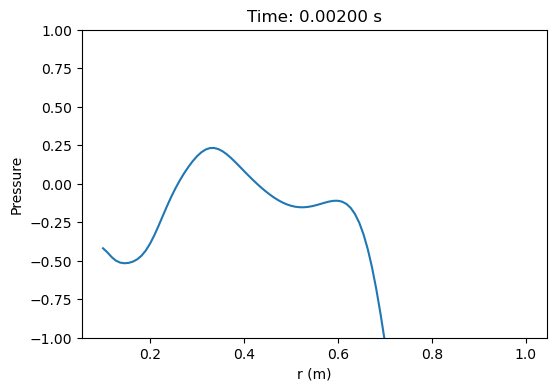

In [59]:
p_rec = model(rt).detach().numpy()
p_rec = p_rec.reshape(r_grid.shape)

fig = plt.figure(figsize=(6, 4))
line, = plt.plot(r, p_rec[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line.set_ydata(p_rec[frame, :])
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line,

ani = FuncAnimation(fig, update, frames=p_rec.shape[0], interval=100, blit=True)
ani.save('wave_animation_model.gif', writer='pillow', fps=10)

In [ ]:
def pde_residual(p, rt, c):
    p_rt = torch.autograd.grad(p, rt, torch.ones_like(p), create_graph=True)[0]
    p_rr = torch.autograd.grad(p_rt[:,0], rt, torch.ones_like(p_rt[:,0]), create_graph=True)[0][:,0:1]
    p_tt = torch.autograd.grad(p_rt[:,1], rt, torch.ones_like(p_rt[:,1]), create_graph=True)[0][:,1:2]
    pde_res = p_rr - p_tt / c**2
    return pde_res

alpha = 1e2
# model_pinn = FCN(n_in, n_out, n_hidden, n_layers)
model_pinn = model
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=1e-3)

n_epochs = int(1e4)

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    
    p = model_pinn(rt_obs)
    loss_obs = mse_loss(p, p_obs)

    r_collocation = torch.randn_like(rt_obs, dtype=torch.float32, requires_grad=True) * torch.tensor([L, T])
    p = model_pinn(r_collocation)
    loss_pde = torch.mean(torch.abs(pde_residual(p, r_collocation, c)**2))

    loss = alpha*loss_obs + loss_pde

    # backpropagate
    loss.backward()
    optimizer.step()
    if i == 0:
        loss_history = []
        loss_obs_history = []
        loss_pde_history = []
    loss_history.append(loss.item())
    loss_obs_history.append(loss_obs.item())
    loss_pde_history.append(loss_pde.item())


  0%|          | 0/10000 [00:00<?, ?it/s]

  9%|▉         | 887/10000 [00:35<06:05, 24.91it/s]


KeyboardInterrupt: 

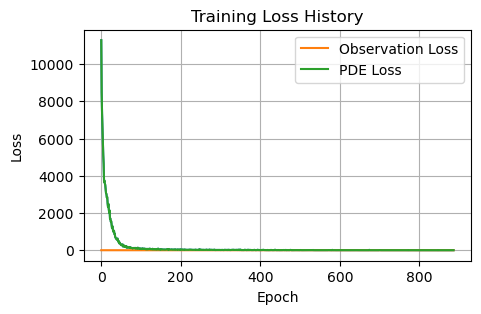

In [65]:
plt.figure(figsize=(5, 3))
plt.plot(np.array(loss_history))
plt.plot(np.array(loss_obs_history)*alpha, label='Observation Loss')
plt.plot(np.array(loss_pde_history), label='PDE Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid()
plt.show()

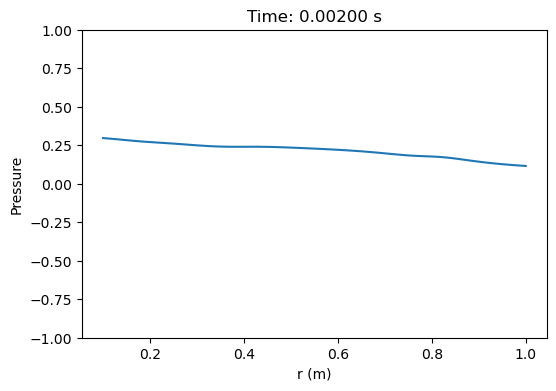

In [66]:
p_rec = model_pinn(rt).detach().numpy()
p_rec = p_rec.reshape(r_grid.shape)

fig = plt.figure(figsize=(6, 4))
line, = plt.plot(r, p_rec[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line.set_ydata(p_rec[frame, :])
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line,

ani = FuncAnimation(fig, update, frames=p_rec.shape[0], interval=100, blit=True)
ani.save('wave_animation_pinn.gif', writer='pillow', fps=10)

Estimate the speed of sound